In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from Utils import plotMetricsGraphComparison # Custom plotting method to compare metrics between models

sb.set() # set the default Seaborn style for graphics

In [2]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

In [3]:
X_train = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test = pd.read_csv('Data/X_test.csv')[columns]
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

test_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

### Decision Tree Classification Model (Without Bagging)

In [4]:
from sklearn.tree import DecisionTreeClassifier
decisionTreeModel = DecisionTreeClassifier(random_state=47)
decisionTreeModel.fit(X_train, Y_train)

# Predict the output based on our training and testing dataset
Y_train_pred = decisionTreeModel.predict(X_train)
Y_test_pred = decisionTreeModel.predict(X_test)

In [5]:
test_metric = {
    "Classification Model": "Decision Tree",
    "Accuracy": accuracy_score(Y_test, Y_test_pred),
    "Precision": precision_score(Y_test, Y_test_pred),
    "Recall": recall_score(Y_test, Y_test_pred),
    "F1 Score": f1_score(Y_test, Y_test_pred)
}

test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.763332,0.422724,0.411415,0.416993


### Applying Bagging to Improve Classification Performance

Previously we made use of decision tree as one of our classification techniques, a possible improvement is we can actually apply bagging. Bagging is an ensembling technique that involves training multiple models independently with subsets of the data, and then combining the prediction. This technique can help improve accuracy and also reduce variance.

To improve the decision tree model via bagging, we can make use of the Random Forest model.

### Random Forest Classification Model (A bagging model that improves over Decision Tree)

In [6]:
from sklearn.ensemble import RandomForestClassifier

randomForestModel = RandomForestClassifier(random_state=47)
randomForestModel.fit(X_train, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred = randomForestModel.predict(X_train)
Y_test_pred = randomForestModel.predict(X_test)

Train and Test Data Confusion Matrix:


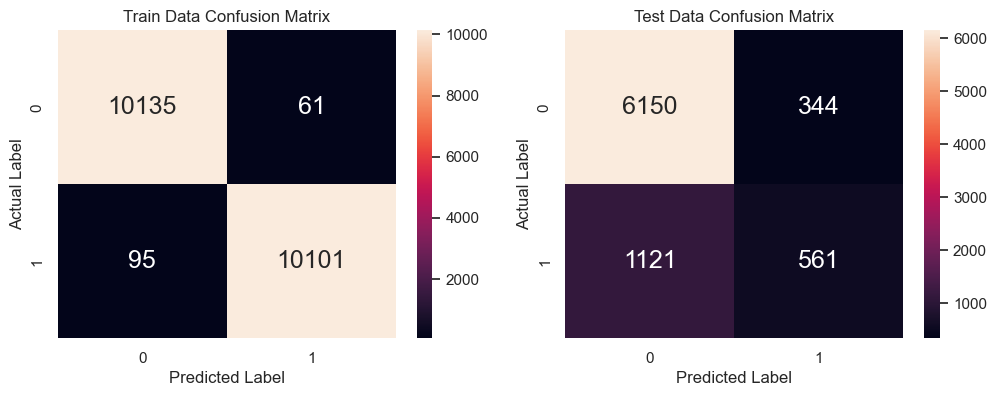

In [7]:
# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(Y_train, Y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
axes[0].set_title('Train Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('Actual Label')

sb.heatmap(confusion_matrix(Y_test, Y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
axes[1].set_title('Test Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('Actual Label')

print("Train and Test Data Confusion Matrix:")

In [8]:
test_metric = {
    "Classification Model": "Random Forest (Default)",
    "Accuracy": accuracy_score(Y_test, Y_test_pred),
    "Precision": precision_score(Y_test, Y_test_pred),
    "Recall": recall_score(Y_test, Y_test_pred),
    "F1 Score": f1_score(Y_test, Y_test_pred)
}

# Save to overall metrics dataframe for comparison later
test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

# Calculate general metrics for the test set
print("**Test Set Metrics**")
print("Accuracy \t:", test_metric["Accuracy"])
print("Precision \t:", test_metric["Precision"])
print("Recall \t\t:", test_metric["Recall"])
print("F1 Score \t:", test_metric["F1 Score"])

**Test Set Metrics**
Accuracy 	: 0.8208170254403131
Precision 	: 0.6198895027624309
Recall 		: 0.3335315101070155
F1 Score 	: 0.43370699652106687


In [9]:
test_metrics.sort_values(by=['Accuracy'], ascending=True,inplace=True)
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.763332,0.422724,0.411415,0.416993
1,Random Forest (Default),0.820817,0.619890,0.333532,0.433707


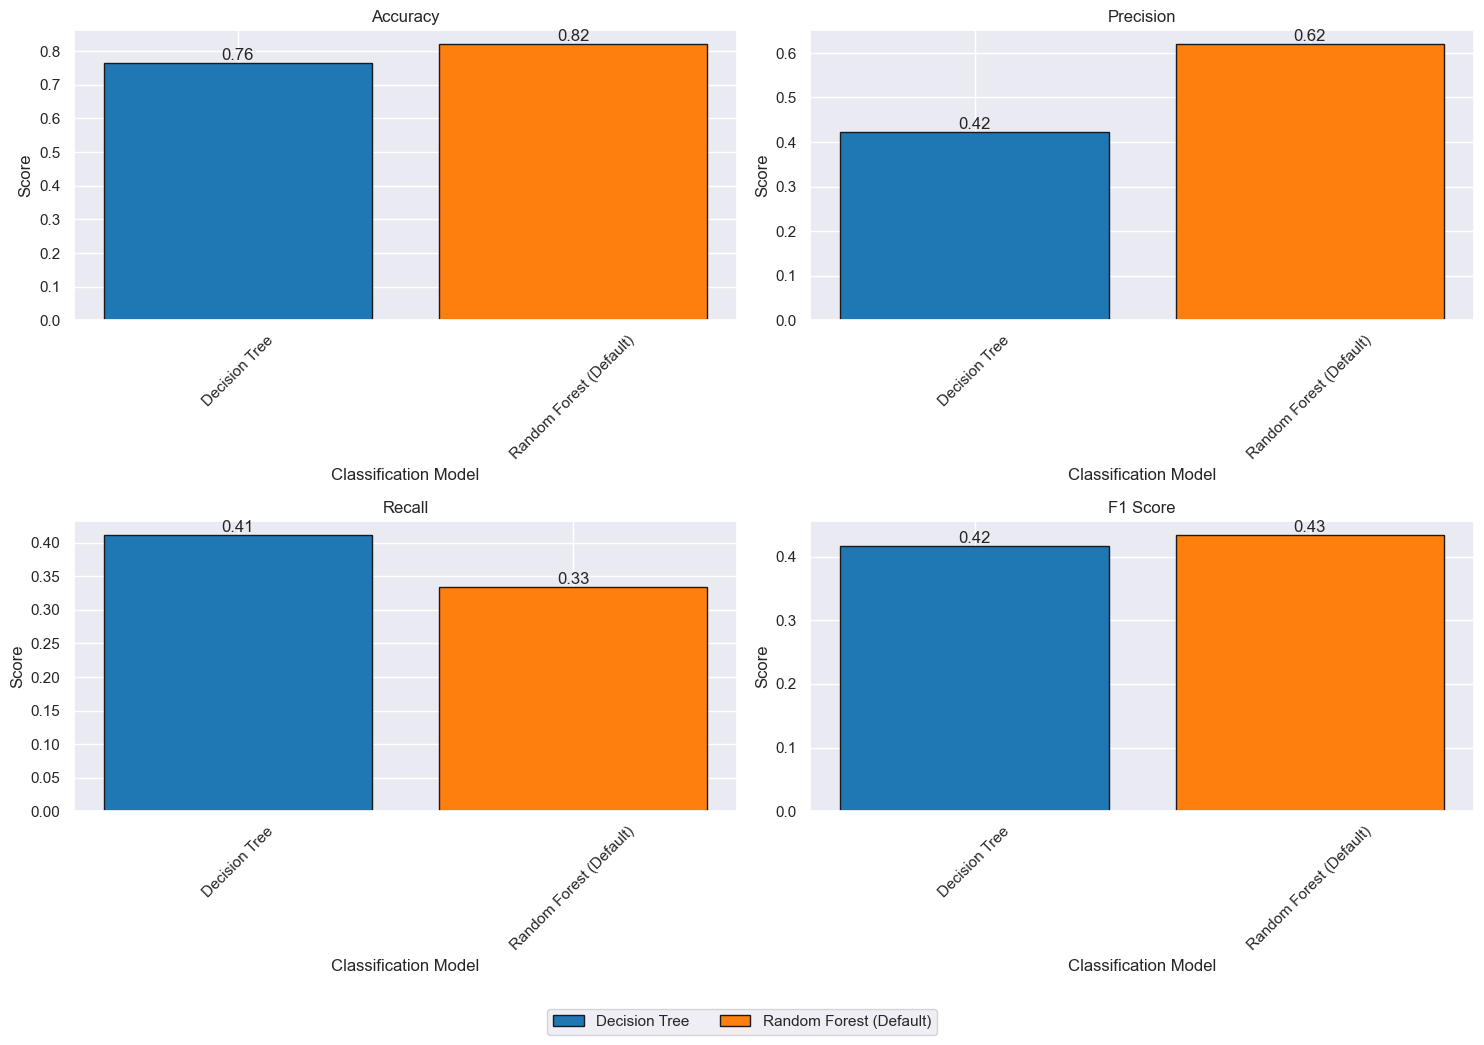

In [10]:
# Custom method for plotting model comparison implemented in the Utils.py file
plotMetricsGraphComparison(test_metrics)

After using bagging to improve Decision Tree, we can actually see Random Forest has the highest accuracy and precision score as compared to the decision tree model.

However, the low recall score is a concern as compared to the decision tree model, it means out of all the actual positive labels, it only correctly identified a low percentage amount. This could be due to reasons such as data imbalances, the data features used for training, to improve this, we will explore feature engineering to create new attributes.

Feature engineering notebook can be found at: [Feature Engineering Notebook](./Feature%20Engineering.ipynb).


### Load Data After Feature Engineering

In [11]:
# Feature engineering was done in the Feature Engineering Notebook, now the feature engineered data is loaded.
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


### Perform Feature Selection on Feature Engineered Data

With the new feature engineered dataset, we have a large number of training features.
This can result in issues such as increased model complexity and the curse of dimensionality where the large number of features results in the distance between different data points seeming close to each other, making it more difficult to distinguish between classes of datapoints during model training.

Hence, one important step we can do to improve on our models is to do feature selection on the feature engineered data.

There are a few ways we can do feature engineering on Random Forest Model:
1. Recursive Feature Elimination
2. Using the Random Forest Feature Importance Statistics to Eliminate Less Important Features
3. Using manual correlation + mutual information approach

We will try all three ways and compare the results at the end, and use the feature selection method that results in the best performance for the Random Forest Model.

### Recursive Feature Elimination (RFE)

The first method is Recursive Feature Elimination (RFE). RFE select features by recursively considering smaller and smaller sets of features. The RFE method will be used in conjunction with cross validation to find the optimal number of features. For each iteration, the scores are averaged across cross validation folds and the number of features selected at the end is set to the number of features that maximize the cross-validation score. 

The internal mechanism of the RFECV is set to be f1 score, because in our context, we want to balance both recall and precision to create a model that is both precise (low false positives where customers who will not cancel are not flagged) and sensitive (high recall with few missed cancellations). 

Implementation of our RFECV method can be found in [FeatureSelectionUtils.py](./FeatureSelectionUtils.py). This is imported in the next line.

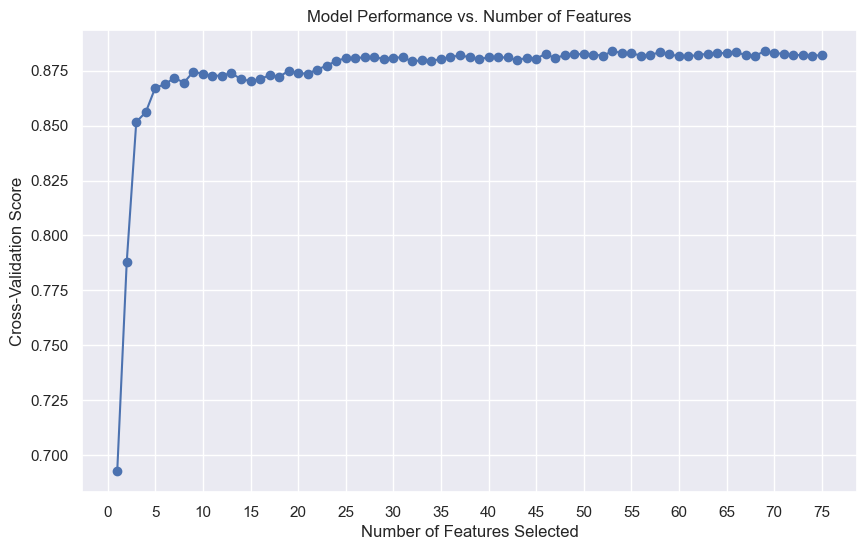

Optimal number of features based on F1 Score: 69


In [12]:
# THIS MAY TAKE AWHILE TO RUN.
from FeatureSelectionUtils import feature_selection_using_rfecv_on_f1score

RandomForestModel = RandomForestClassifier(random_state=47)
featuresSelectionScoreBasedOnRFECV = feature_selection_using_rfecv_on_f1score(RandomForestModel, X_train, Y_train)

In [13]:
# This dataframe highlights the attributes, whether they're selected based on the most optimal number of features, and their ranking
featuresSelectionScoreBasedOnRFECV

,attribute,selected,ranking
0,traveller_type_adults_only,True,1
1,traveller_type_children_only,True,1
2,traveller_type_mixed,True,1
3,stay_type_hour_room,False,2
4,stay_type_mixed,True,1
...,...,...,...
70,no_of_previous_cancellations_scaled,True,1
71,no_of_previous_bookings_not_canceled_scaled,True,1
72,no_of_special_requests_scaled,True,1
73,lead_time_scaled,True,1


From here the graph above, we can see that the optimal number of features calculated using RFECV. These features will be kept in the Random Forest models, and those that did not qualify will be dropped based on the RFECV method.

Now, we use these set of selected features to train the Random Forest Model again.

In [14]:
non_selected_features_RFECV = featuresSelectionScoreBasedOnRFECV[featuresSelectionScoreBasedOnRFECV['selected'] == False]['attribute'].tolist()

# Drop the non-selected features
X_train_filtered_RFECV = X_train.drop(columns=non_selected_features_RFECV)
X_test_filtered_RFECV = X_test.drop(columns=non_selected_features_RFECV)

print("Train Set :", Y_train.shape, X_train_filtered_RFECV.shape)
print("Test Set  :", Y_test.shape, X_test_filtered_RFECV.shape)


Train Set : (20392, 1) (20392, 69)
Test Set  : (8176, 1) (8176, 69)


In [15]:
randomForestModelWithRFECV = RandomForestClassifier(random_state=47)
randomForestModelWithRFECV.fit(X_train_filtered_RFECV, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred = randomForestModelWithRFECV.predict(X_train_filtered_RFECV)
Y_test_pred = randomForestModelWithRFECV.predict(X_test_filtered_RFECV)

test_metric = {
    "Classification Model": "Random Forest (RFECV)",
    "Accuracy": accuracy_score(Y_test, Y_test_pred),
    "Precision": precision_score(Y_test, Y_test_pred),
    "Recall": recall_score(Y_test, Y_test_pred),
    "F1 Score": f1_score(Y_test, Y_test_pred)
}

# Save to overall metrics dataframe for comparison later
test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.763332,0.422724,0.411415,0.416993
1,Random Forest (Default),0.820817,0.619890,0.333532,0.433707
2,Random Forest (RFECV),0.817882,0.566967,0.485731,0.523215


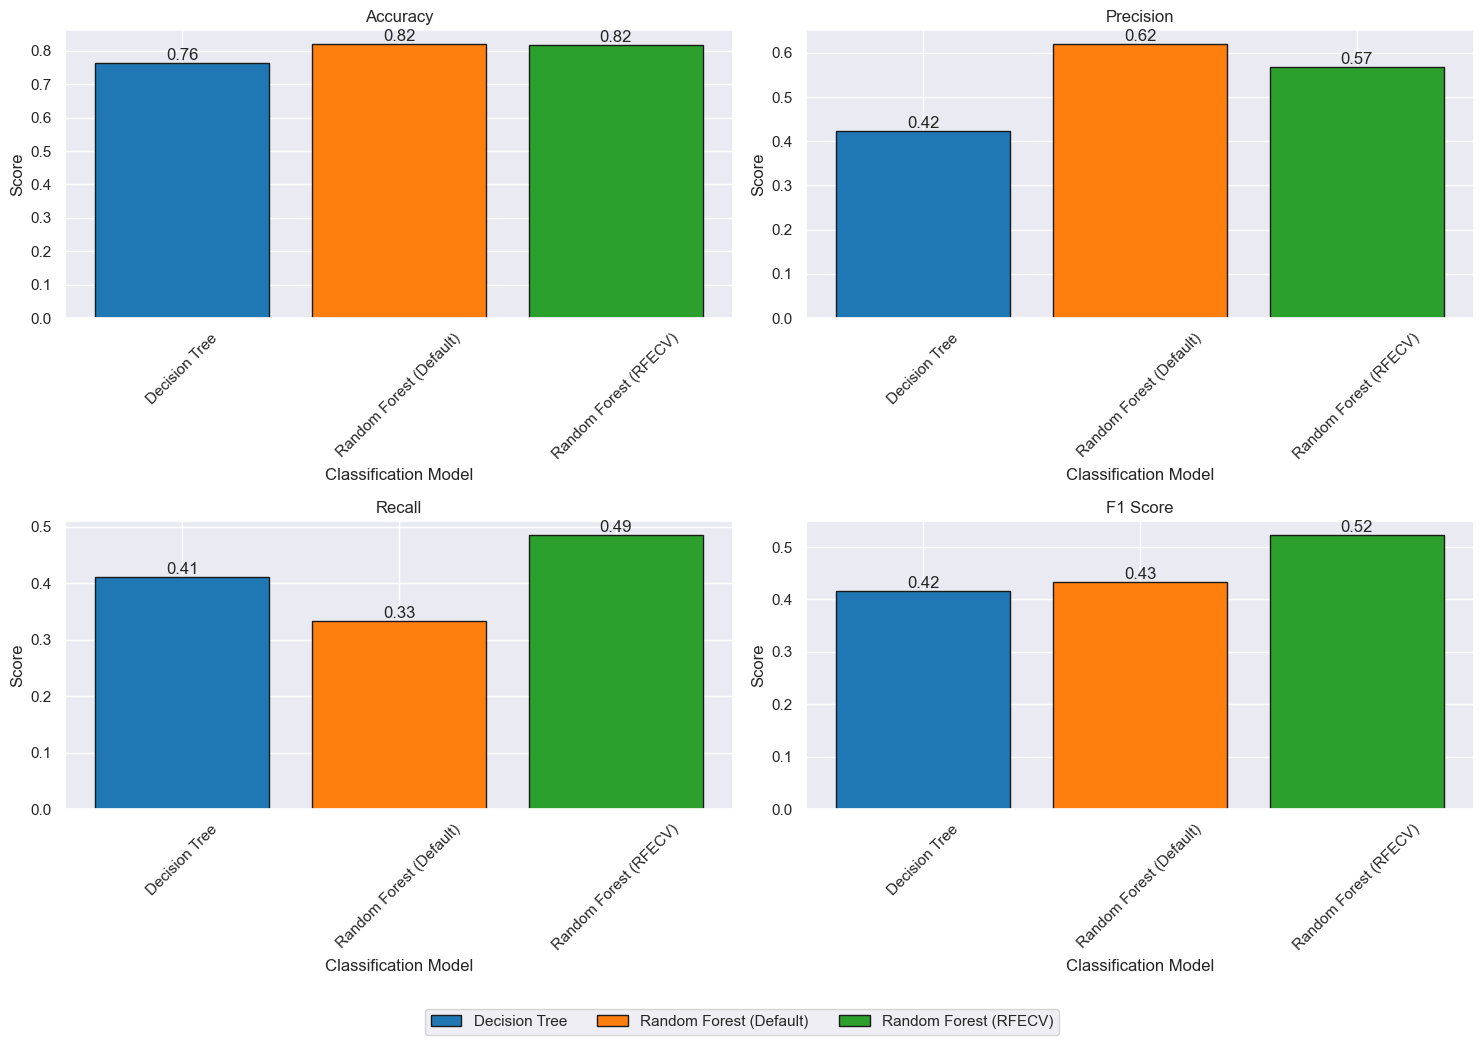

In [16]:
plotMetricsGraphComparison(test_metrics)

Here we can see that the accuracy from the default Random Forest and the Random Forest after Feature Selection with RFECV is similar, but however, if we look at the f1 score from, there has been a big improvement. This means the Feature Selection with RFECV has resulted in a positive improvement from our default models.

But however, this is still too early to say if its the best method, let's try our feature selection methods.

### Using the Random Forest Feature Importance Statistics to Eliminate Less Important Features

In [17]:
# Custom created method to compute permutance and feature importance.
from FeatureSelectionUtils import compute_permutation_importance
from FeatureSelectionUtils import plot_feature_importance

RandomForestModel = RandomForestClassifier(random_state=47)
RandomForestModel.fit(X_train, Y_train.values.ravel())
permutance_importance = compute_permutation_importance(RandomForestModel, X_train, Y_train)
features_importance_score = permutance_importance[0]
features = permutance_importance[1]

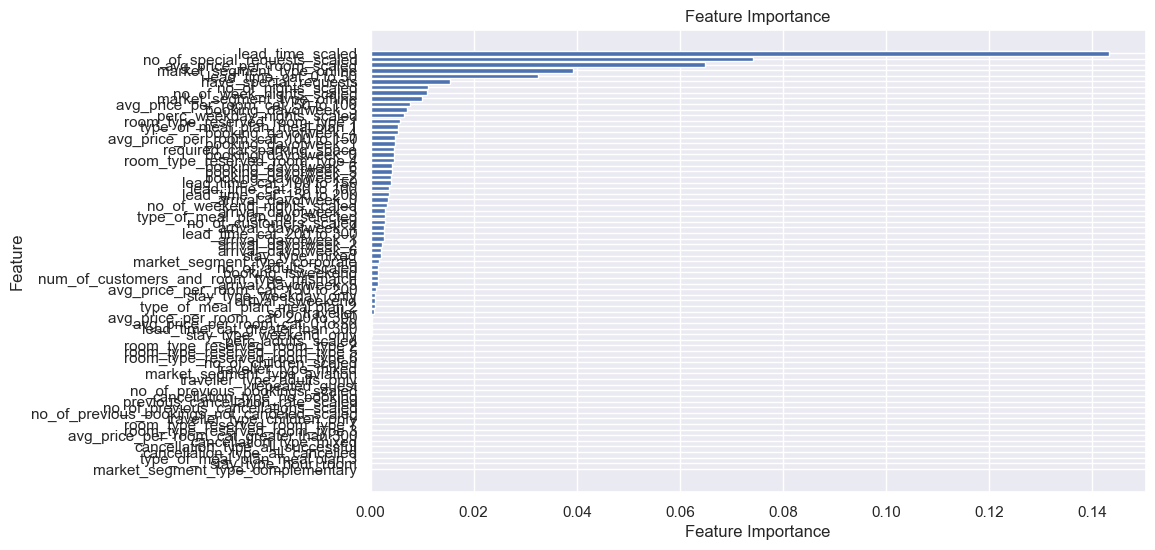

In [18]:
plot_feature_importance(features_importance_score, features)

The above graph shows the list of feature importance, we can see that many features have close to 0 feature importance! This means those features are not very important for training the model, hence we can actually make use of a threshold to find out what these features are. Subsequently, we can drop them from our X columns as seen in the code below:

In [19]:
# Define the cutoff threshold
cutoff_threshold = 0.0001

non_important_features_boolean = features_importance_score <= cutoff_threshold
non_important_features = features[non_important_features_boolean]

# Drop the non-important features
X_train_filtered_feature_importance = X_train.drop(columns=non_important_features)
X_test_filtered_feature_importance = X_test.drop(columns=non_important_features)

print("Train Set :", Y_train.shape, X_train_filtered_feature_importance.shape)
print("Test Set  :", Y_test.shape, X_test_filtered_feature_importance.shape)

Train Set : (20392, 1) (20392, 56)
Test Set  : (8176, 1) (8176, 56)


In [20]:
randomForestModelWithFeatureImportance = RandomForestClassifier(random_state=47)
randomForestModelWithFeatureImportance.fit(X_train_filtered_feature_importance, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred = randomForestModelWithFeatureImportance.predict(X_train_filtered_feature_importance)
Y_test_pred = randomForestModelWithFeatureImportance.predict(X_test_filtered_feature_importance)

In [21]:
test_metric = {
    "Classification Model": "Random Forest (Feature Importance)",
    "Accuracy": accuracy_score(Y_test, Y_test_pred),
    "Precision": precision_score(Y_test, Y_test_pred),
    "Recall": recall_score(Y_test, Y_test_pred),
    "F1 Score": f1_score(Y_test, Y_test_pred)
}

# Save to overall metrics dataframe for comparison later
test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.763332,0.422724,0.411415,0.416993
1,Random Forest (Default),0.820817,0.619890,0.333532,0.433707
2,Random Forest (RFECV),0.817882,0.566967,0.485731,0.523215
3,Random Forest (Feature Importance),0.812133,0.550069,0.476813,0.510828


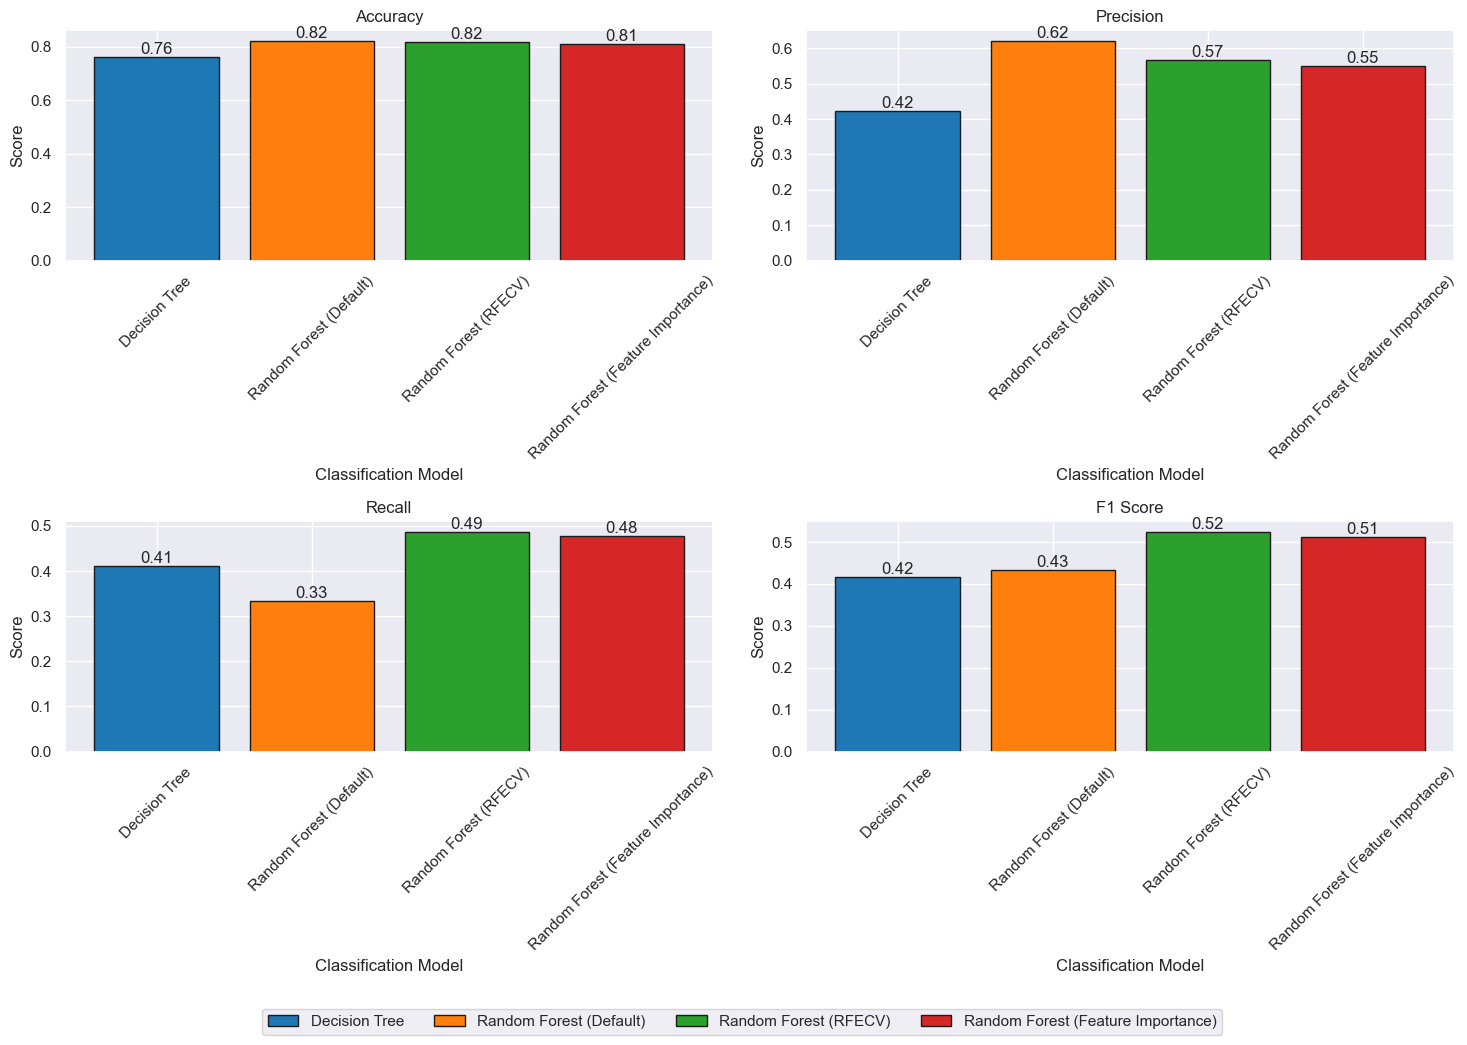

In [22]:
plotMetricsGraphComparison(test_metrics)

With manual feature importance selection, we see the results is quite similar to Random Forest with RFECV for feature selection, it is still an improvement from the default Random Forest, but overall it seems to perform slightly worst than the RFECV method for feature selection.

Next, let's try to eliminate feature through correlation and mutual information.

### Using the Correlation and Mututal Information To Do Feature Selection
The idea here is to eliminate features who are strongly related to another feature, since the information/benefits from the feature would also be contained in the other feature, we can eliminate one of the feature to reduce dimensionality.

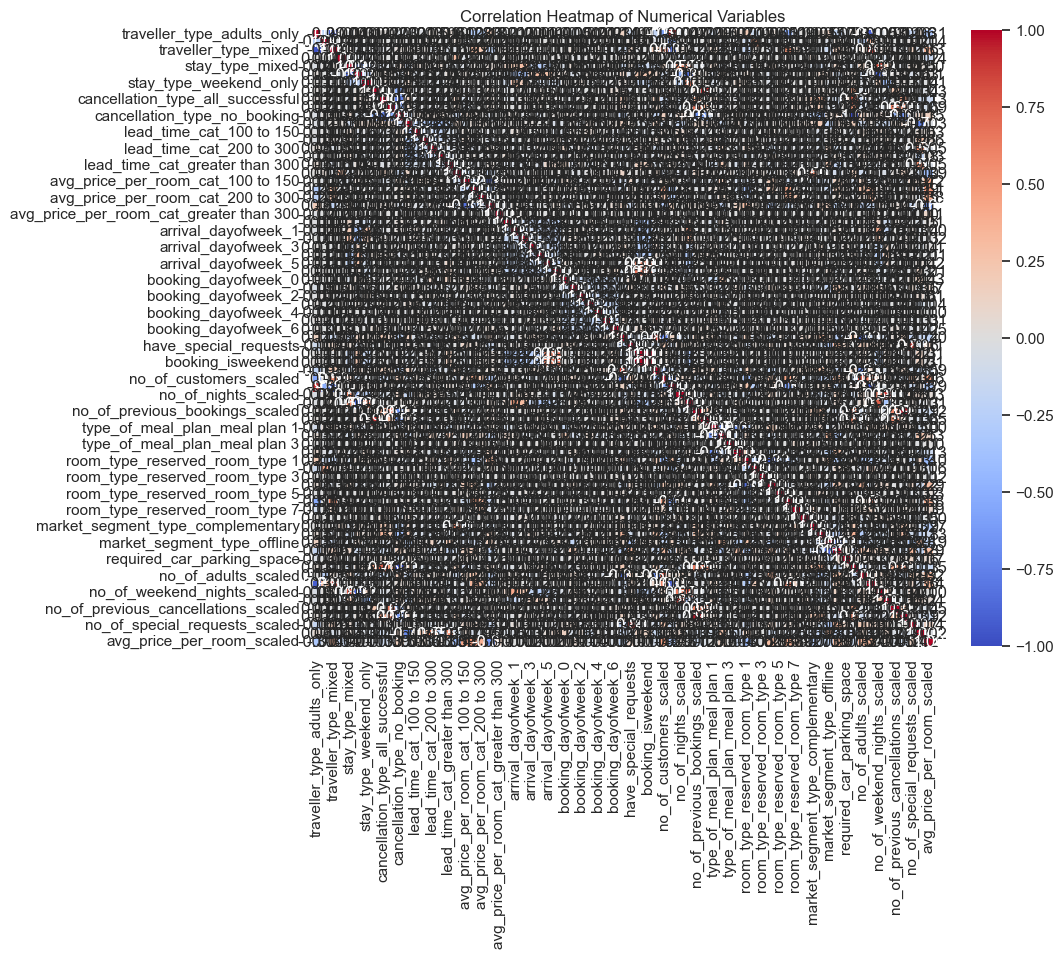

In [23]:
corr = X_train.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sb.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

Due to the number of features, it is not possible to view the correlation of the heatmap directly. Hence let's use a threshold to detect the correlation through code instead. 

Also when identifying pairs of correlated feature, how do we know which one to drop? The first feature or the second feature that is correlated. We will use the feature importance score to help us automatically determine which one is less important to drop.

In addition, a threshold is set to determine what features are highly correlated.

In [24]:
corr_matrix = X_train.corr().abs()

# Set the correlation threshold on determining what correlation to drop for feature selection
threshold = 0.8

# Correlation matrix with only the upper triangle (since the correlation is mirrored, we only need one side)
corr_matrix_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in corr_matrix_upper.columns if any(corr_matrix_upper[column] > threshold)]

rf = RandomForestClassifier(random_state=47)  
rf.fit(X_train, Y_train.values.ravel())

importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=["Importance"])
X_train_filtered_correlation = X_train.copy()
X_test_filtered_correlation = X_test.copy()

dropped_features = set()

# For each pair of highly correlated features above threshold, drop them from X_train
for column in to_drop:
    if column not in dropped_features:
        
        # Check our upper to find the features that are correlated to it, with a high threshold score
        correlated_features = list(corr_matrix_upper.index[corr_matrix_upper[column] > threshold])
        correlated_with_importances = correlated_features + [column]
        correlated_with_importances = [f for f in correlated_with_importances if f not in dropped_features]
        
        # If there are highly correlated features in this column
        if correlated_with_importances:
            # Find the feature with the least importance and drop it
            least_important_feature = importances.loc[correlated_with_importances, "Importance"].idxmin()
            X_train_filtered_correlation.drop(columns=least_important_feature, inplace=True)
            X_test_filtered_correlation.drop(columns=least_important_feature, inplace=True)
            dropped_features.add(least_important_feature)

Here we can see the remaining features after dropping the highly correlated ones.

In [25]:
X_train_filtered_correlation.info()

print("")
print("Train Set :", Y_train.shape, X_train_filtered_correlation.shape)
print("Test Set  :", Y_test.shape, X_test_filtered_correlation.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20392 entries, 0 to 20391
Data columns (total 58 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   traveller_type_children_only             20392 non-null  float64
 1   stay_type_hour_room                      20392 non-null  float64
 2   stay_type_mixed                          20392 non-null  float64
 3   stay_type_weekend_only                   20392 non-null  float64
 4   cancellation_type_all_successful         20392 non-null  float64
 5   cancellation_type_mixed                  20392 non-null  float64
 6   lead_time_cat_0 to 50                    20392 non-null  float64
 7   lead_time_cat_100 to 150                 20392 non-null  float64
 8   lead_time_cat_150 to 200                 20392 non-null  float64
 9   lead_time_cat_200 to 300                 20392 non-null  float64
 10  lead_time_cat_50 to 100                  20392

Now let's also try to apply mutual information to drop any features that have high mutual information (indicating they're highly related).

Mutual Information is only used for discrete values. Hence we will check Mutual Information between the discrete variables to drop any highly dependent variables.

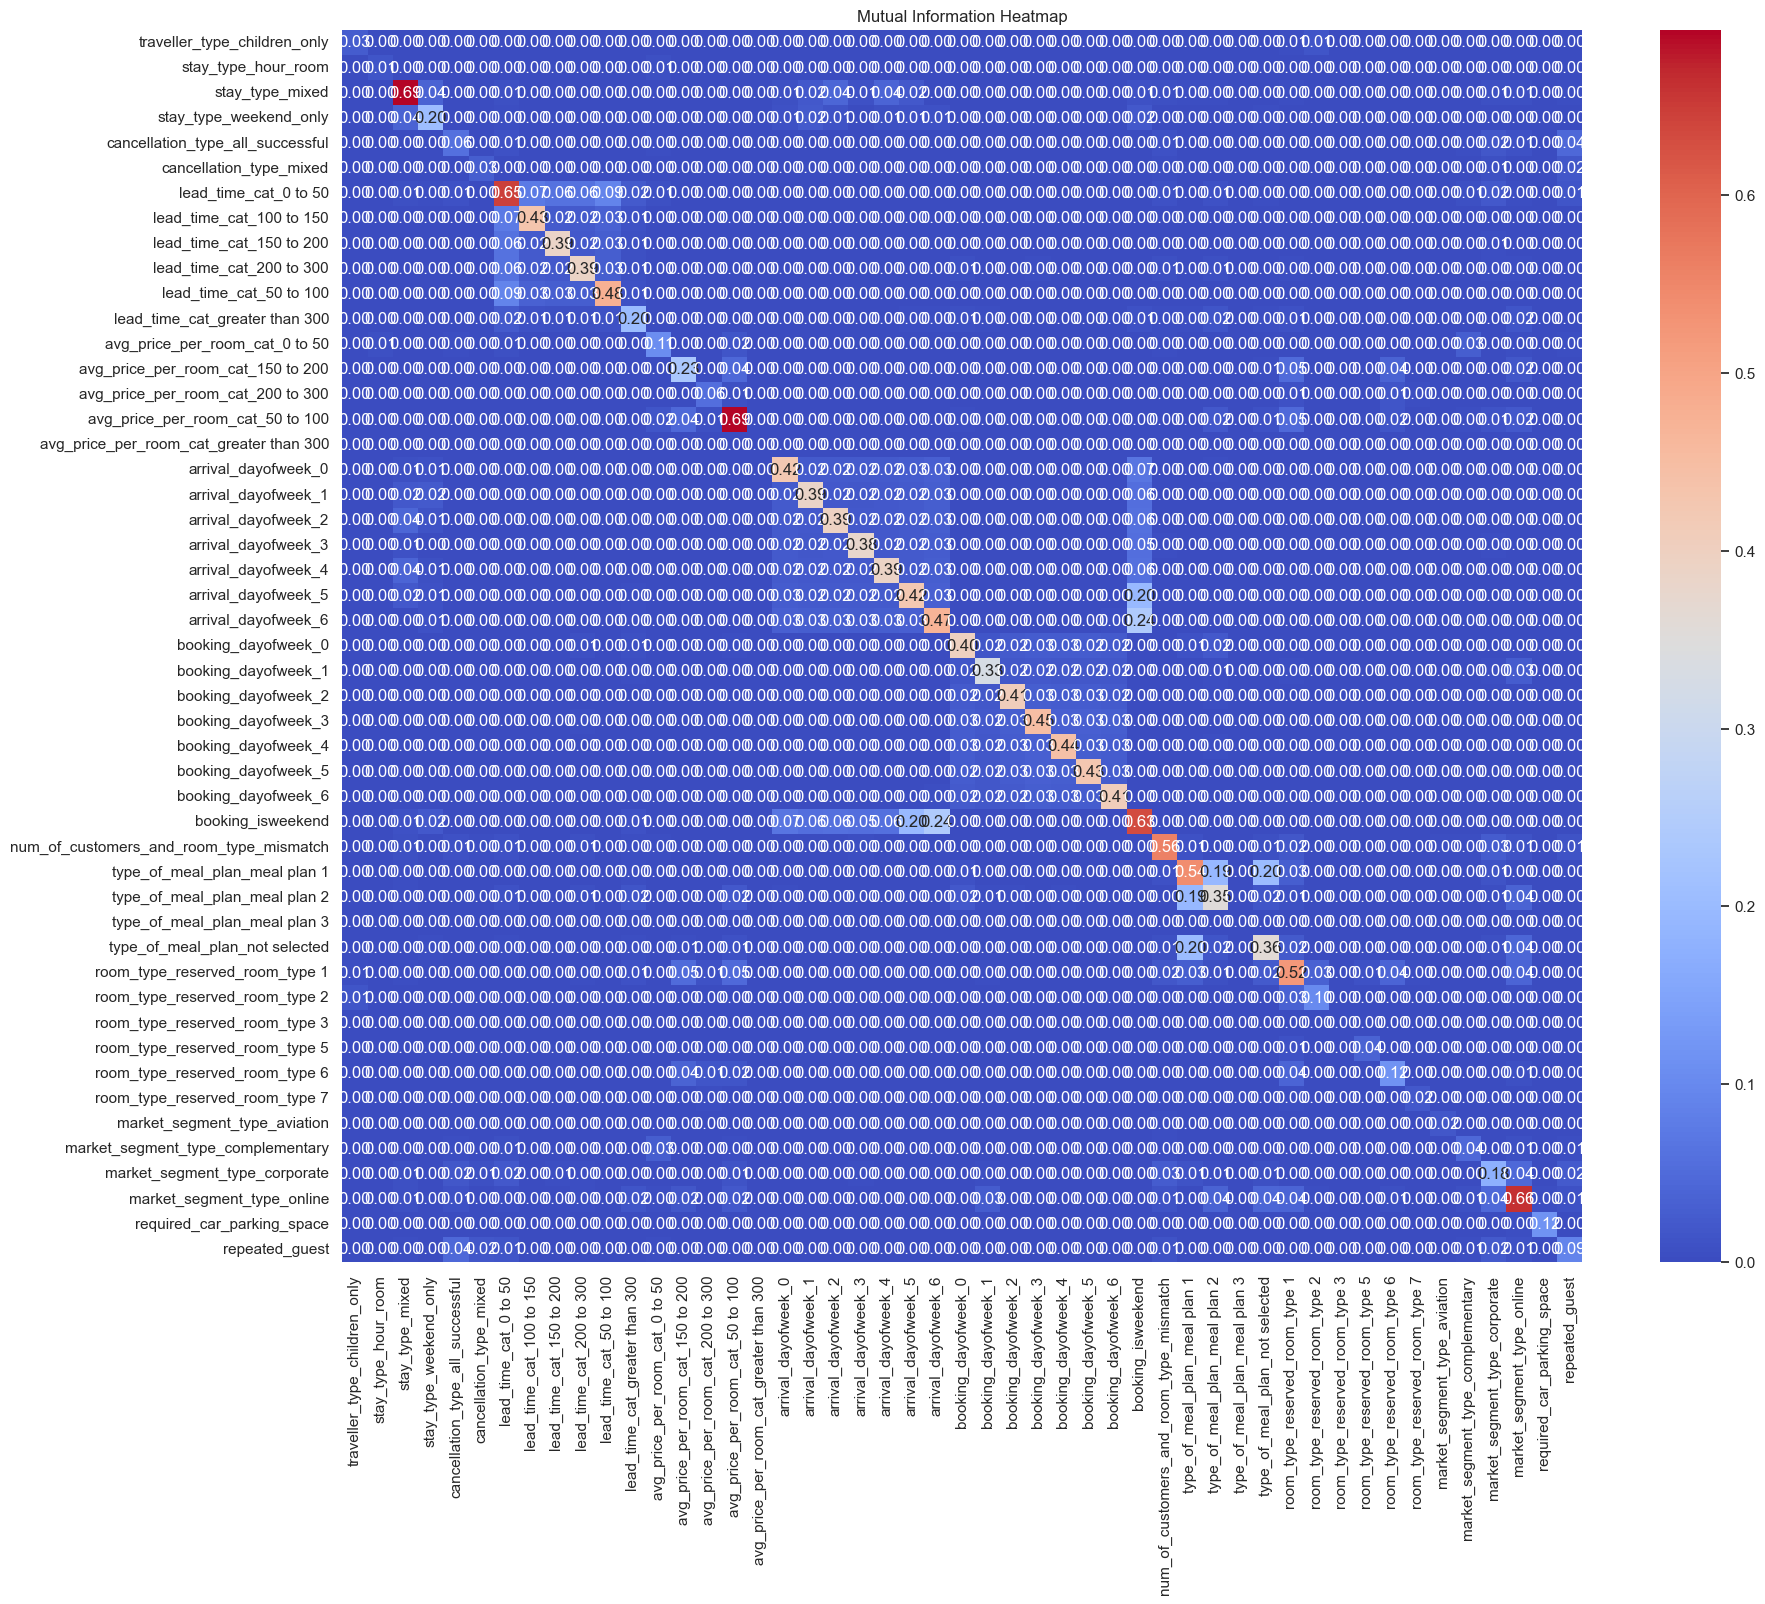

Features to drop based on high MI: {'arrival_dayofweek_6', 'type_of_meal_plan_not selected'}


In [26]:
from sklearn.metrics import mutual_info_score

def calculate_mutual_info(df, col1, col2):
        return mutual_info_score(df[col1], df[col2])
    
# Determine the discrete columns
cat_cols = [x for x in X_train_filtered_correlation.columns if '_scaled' not in x]

# plot heatmap
mi_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)
for i in cat_cols:
    for j in cat_cols:
        mi_matrix.loc[i, j] = calculate_mutual_info(X_train_filtered_correlation, i, j)

plt.figure(figsize=(20, 16))
sb.heatmap(mi_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mutual Information Heatmap')
plt.show()

threshold = 0.2
features_dropped = set()

for i in cat_cols:
    for j in cat_cols:
        if mi_matrix.loc[i, j] > threshold and i != j:
            if mi_matrix.loc[i].sum() > mi_matrix.loc[j].sum():
                features_dropped.add(j)
            else:
                features_dropped.add(i)


print("Features to drop based on high MI:", features_dropped)

In [27]:
X_train_filtered_correlation_and_mi = X_train_filtered_correlation.drop(columns=features_dropped)
X_test_filtered_correlation_and_mi = X_test_filtered_correlation.drop(columns=features_dropped)

print("Train Set :", Y_train.shape, X_train_filtered_correlation_and_mi.shape)
print("Test Set  :", Y_test.shape, X_test_filtered_correlation_and_mi.shape)

Train Set : (20392, 1) (20392, 56)
Test Set  : (8176, 1) (8176, 56)


With this new set of engineered features using correlation and mutual information, lets try to train the random forest again.

In [28]:
randomForestModelWithCorrAndMI = RandomForestClassifier(random_state=47)
randomForestModelWithCorrAndMI .fit(X_train_filtered_correlation_and_mi, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred = randomForestModelWithCorrAndMI.predict(X_train_filtered_correlation_and_mi)
Y_test_pred = randomForestModelWithCorrAndMI.predict(X_test_filtered_correlation_and_mi)

In [29]:
test_metric = {
    "Classification Model": "RF (Corr and MI)",
    "Accuracy": accuracy_score(Y_test, Y_test_pred),
    "Precision": precision_score(Y_test, Y_test_pred),
    "Recall": recall_score(Y_test, Y_test_pred),
    "F1 Score": f1_score(Y_test, Y_test_pred)
}

# Save to overall metrics dataframe for comparison later
test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)
test_metrics

**Test Set Metrics**
Accuracy 	: 0.8123776908023483
Precision 	: 0.553314121037464
Recall 		: 0.45659928656361476
F1 Score 	: 0.5003257328990228


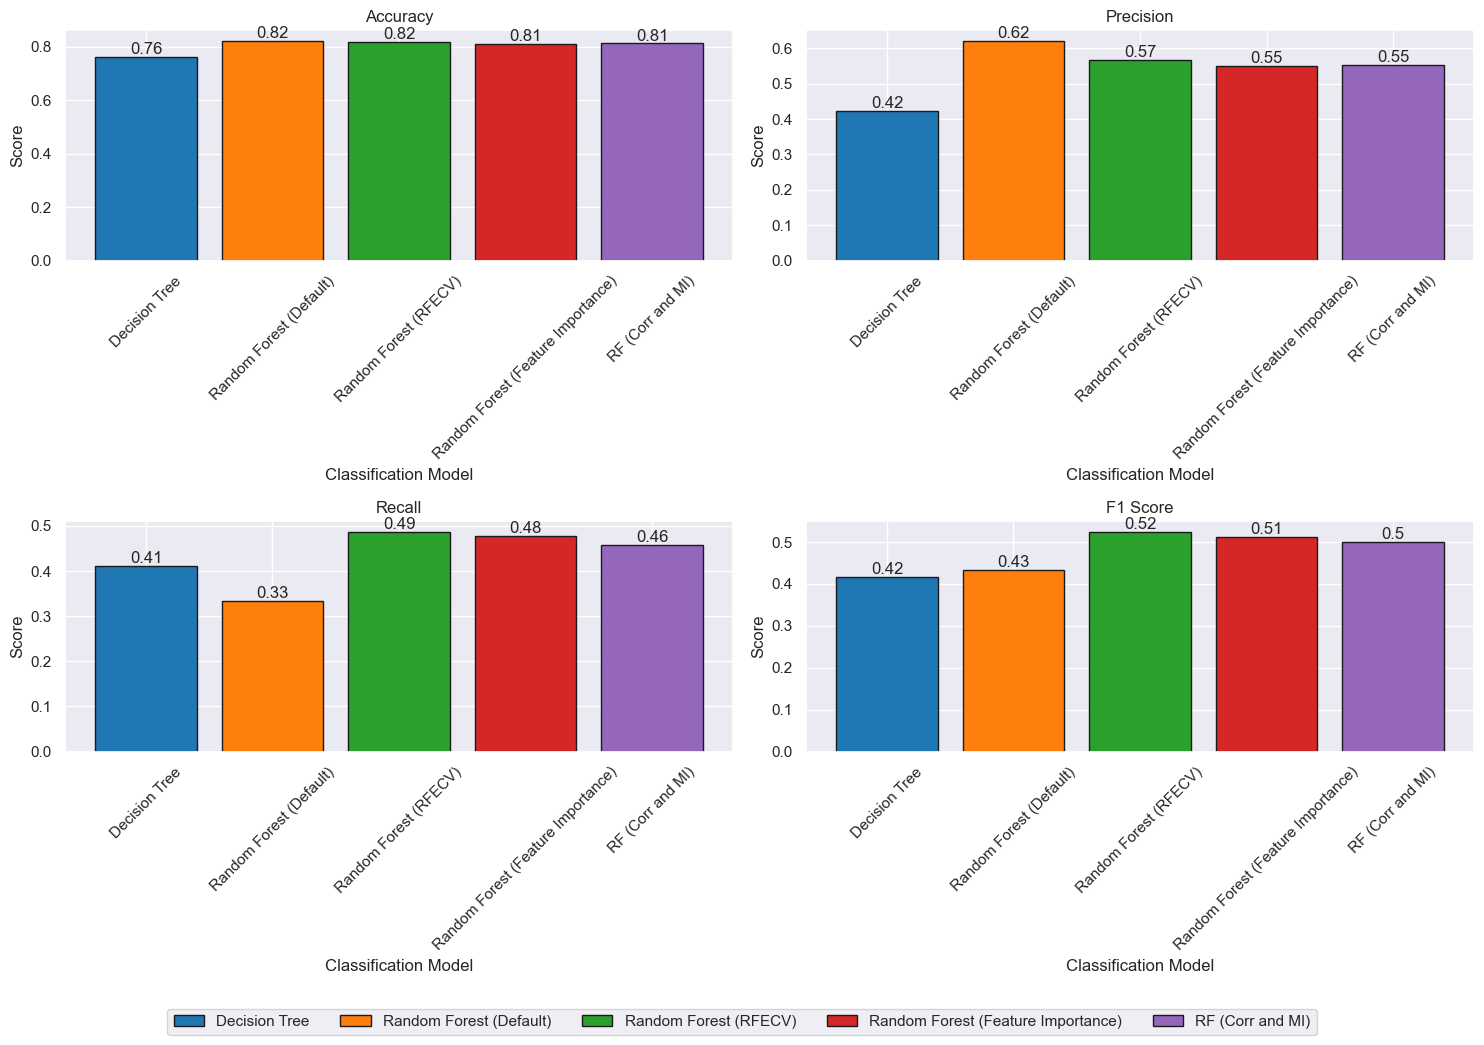

In [31]:
plotMetricsGraphComparison(test_metrics)

#### Comparing the different feature selection methods:
1. Recursive Feature Elimination
2. Using the Random Forest Feature Importance Statistics to Eliminate Less Important Features
3. Using manual correlation + mutual information approach

We see that RFECV seems to perform the best based on the overall performance using accuracy and f1 score, hence this is the feature selection method that will be kept.

### Further Improvements - Hyperparameter Tuning

Now with the new feature selected, we can try to improve the random forest model by tuning its hyper parameters. GridSearchCV and RandomizedSearchCV is a popular way to try hyperparameter tuning with different parameters with Cross Validation.

In our example, we will use RandomizedSearchCV due to the large parameter search space, randomizedsearchCV can help reduce the number of iterations but still explore a diverse set of parameters.

In [32]:
from sklearn.model_selection import RandomizedSearchCV

# Current data after feature selection
print("Train Set :", Y_train.shape, X_train_filtered_RFECV.shape)
print("Test Set  :", Y_test.shape, X_test_filtered_RFECV.shape)

Train Set : (20392, 1) (20392, 69)
Test Set  : (8176, 1) (8176, 69)


For Random Forest, these are the set of parameters we can tune:
1. n_estimators = the number of trees
2. max_features = no of features to consider for splitting
3. max_depth = max depth of each tree
4. min_samples_split = minimum sample to split a node
5. min_samples_leaf = minimum samples in a leaf node
6. bootstrap = to use bootstrap samples to introduce randomness, potentially help model generalise better

In [33]:
# NOTE THIS MAY TAKE AWHILE TO RUN!

no_of_features = len(X_train_filtered_RFECV.columns)

parameters = {
    # We set n_estimators to different tree sizes
    'n_estimators': [10, 20, 50],
    # Try the different ways to select no of features to consider during each split
    'max_features': ['sqrt', 'log2'],
    # To avoid overfitting, we want to prevent a high max depth
    'max_depth': [10, 20, 30],
    'min_samples_split':[2, 10, 20], 
    'min_samples_leaf': [1, 2, 5, 10],
    # To test whether if bootstrapping (which will introduce some randomness) will help the model
    'bootstrap': [True, False]
}

randomForestModel = RandomForestClassifier(random_state=47)

# Run RandomizedSearchCV with Random Forest with the above parameters with 200 iterations and cross validation folds of 5.
gridSearchWithRFModel = RandomizedSearchCV(estimator=randomForestModel, random_state=47, param_distributions=parameters, n_iter=200, cv=5, n_jobs=-1, verbose=2)
gridSearchWithRFModel.fit(X_train_filtered_RFECV, Y_train.values.ravel())

print("Best params from gridsearchcv:", gridSearchWithRFModel.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params from gridsearchcv: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


Based on the output results from RandomizedSearchCV, we will then use this parameters for our final model to see the results of training random forest using both RFECV + Hypertuned parameters.

In [37]:
randomForestModelTuned = RandomForestClassifier(random_state=47, n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features="sqrt", max_depth=30, bootstrap=False)
randomForestModelTuned.fit(X_train_filtered_RFECV, Y_train.values.ravel())

# Predict the output based on our training and testing dataset
Y_train_pred = randomForestModelTuned.predict(X_train_filtered_RFECV)
Y_test_pred = randomForestModelTuned.predict(X_test_filtered_RFECV)

test_metric = {
    "Classification Model": "Final RF (RFECV + Tuning)",
    "Accuracy": accuracy_score(Y_test, Y_test_pred),
    "Precision": precision_score(Y_test, Y_test_pred),
    "Recall": recall_score(Y_test, Y_test_pred),
    "F1 Score": f1_score(Y_test, Y_test_pred)
}

# Save to overall metrics dataframe for comparison later
test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.763332,0.422724,0.411415,0.416993
1,Random Forest (Default),0.820817,0.619890,0.333532,0.433707
2,Random Forest (RFECV),0.817882,0.566967,0.485731,0.523215
3,Random Forest (Feature Importance),0.812133,0.550069,0.476813,0.510828
4,RF (Corr and MI),0.812378,0.553314,0.456599,0.500326
5,Final RF (RFECV + Tuning),0.823386,0.582296,0.500595,0.538363


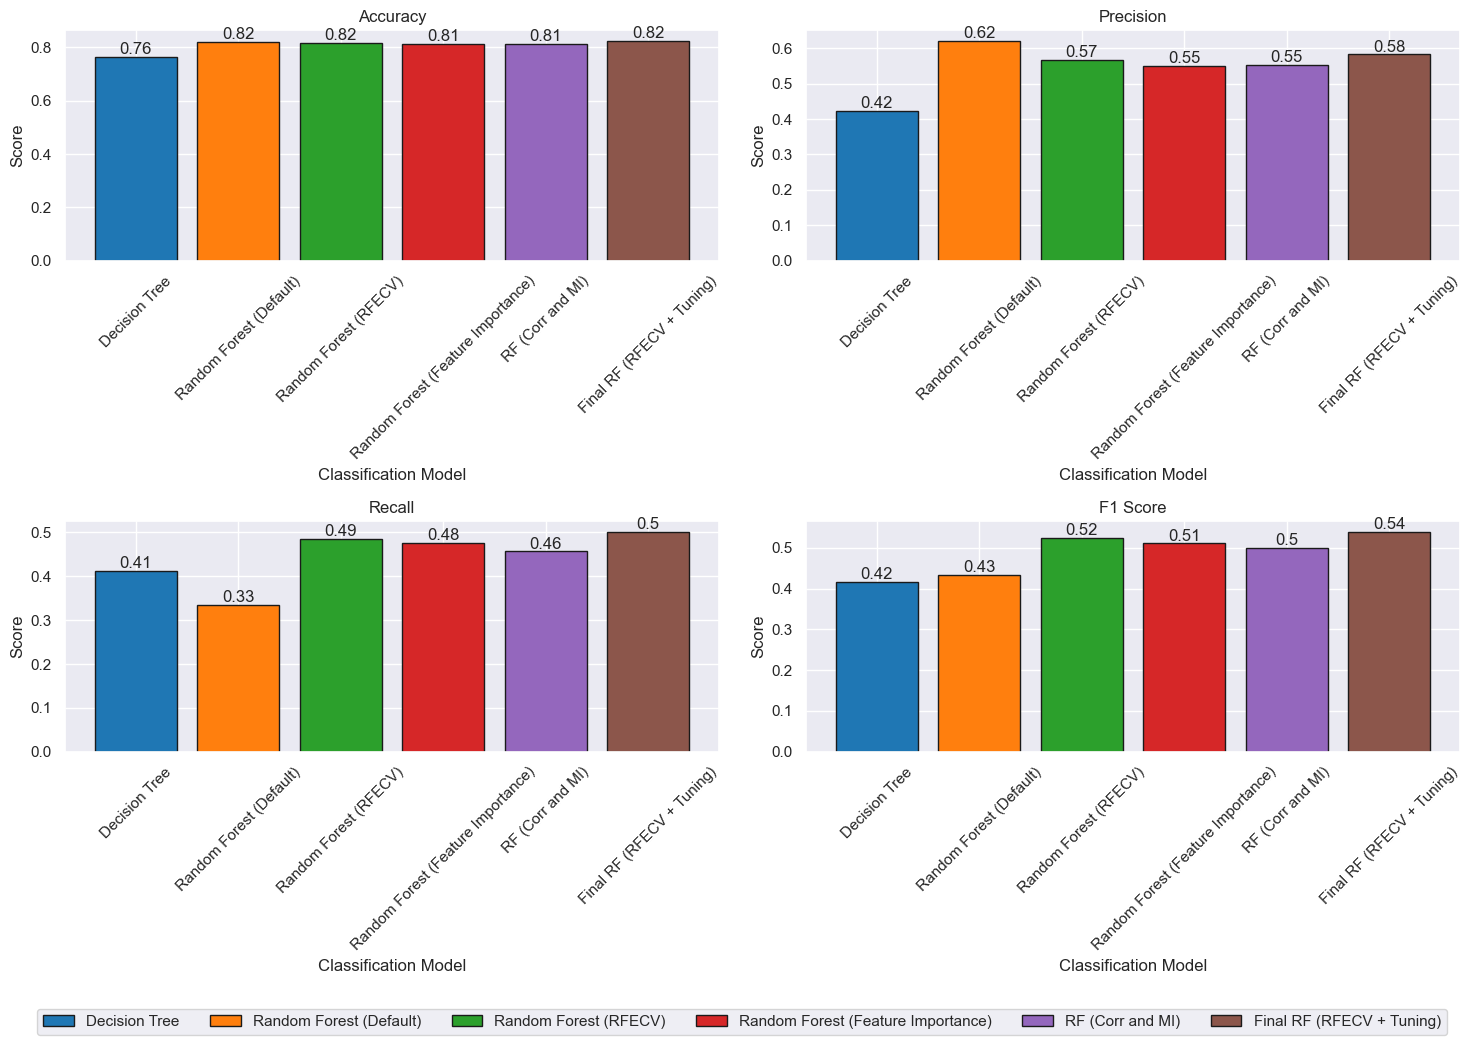

In [36]:
plotMetricsGraphComparison(test_metrics)

The final random forest model with RFECV feature selection and hyperparameter tuning (Brown) seem to outperform the other models overall. 

The accuracy
One huge improvement that can be noticed is the higher F1 Score, which is one of the most important metric in our context, since we want to balance both recall and precision to create a model that is both precise (low false positives where customers who will not cancel are not flagged) and sensitive (high recall with few missed cancellations).



Thus, for random forest models, we will select Random Forest with Feature Selection + Hyperparameter as the best model.

The next step here would be to compare the best random forest model against the other classification models in the final jupyter notebook that consolidates the results.